In [1]:
import csv
import os
import cv2
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from convnet import ConvNet
from sklearn.metrics import classification_report

from lightning_model import LightningModel


# np.random.seed(42)

In [2]:
ROOT_DATA_PATH = '/s/babbage/e/nobackup/nkrishna/m3x/others/data/'
train_set = ROOT_DATA_PATH + 'train.csv'
test_set = ROOT_DATA_PATH + 'test.csv'
images = ROOT_DATA_PATH + 'images/'

In [3]:
train_labels = pd.read_csv(train_set)
test_labels = pd.read_csv(test_set)


1678816535    4310
1678736713    4146
1678761262    4085
1678766920    3824
1678739903    3609
1678344738    3371
1678594405    3080
1678337873    2937
1679267208    2856
1678589738    2775
1678819096    2696
1679265796    2471
1678341667    2416
1679270824    2374
1679011935    2189
1678445757    2142
1678454755    2060
1679008414    1939
1678414274    1860
1679009928    1702
1678333984    1696
1678450861    1681
1678580155    1572
1678415191    1458
1679221334    1443
1678591103    1333
1679007451    1122
1678413653    1083
1678593348    1025
1678835470     957
1678832038     857
1672777638     829
1678834100     803
1678419624     679
1678453862     659
1672868532     593
1672858778     593
1672773342     593
1672774625     574
1672794804     572
1672781765     492
1672793440     465
1672780647     440
1672857603     389
1678834870     358
1672775511     342
1672792990     341
1672779510     334
1672767789     308
1672709609     307
1672782493     213
1672794032     107
Name: print_

In [9]:
test_labels.print_id.value_counts()

1679222113    3476
1678744931    2402
1678764144    1953
1678452362    1445
1678343246    1058
1673041994     950
1673034918     946
1678578332     869
1673046546     792
1673047933     792
1679011090     767
1673031848     716
1673041144     716
1672776024     633
1672795514     621
1678831256     508
1674182025     404
1674184477     404
1674179039     391
1673038169     322
1674183481     312
1674187131     312
1674180283     302
1673032842     302
1673047525     299
1673034242     291
1673040671     291
1673040188     287
1673025450     286
1674182884     251
1674186076     235
1674179701     220
1673037665     210
1673043651     208
1673043367     191
1673037348     191
1673043066     180
1673037071     180
1674183959     133
1674185002     132
1674180772     117
1674185462      66
1674184223      62
1674181142      56
Name: print_id, dtype: int64

In [16]:
from transformers import AutoFeatureExtractor



PRINT_IDS_FOR_VAL_ONLY = []
PRINTERS_FOR_VAL_ONLY = []
CUTOFF_PRINTS = 1500

def get_images_and_targets(labels_df: pd.DataFrame, images_path: str, image_processor: AutoFeatureExtractor, test=False, train_fraction=0.7, val=False, lesser=True):
    
    
    PRINTS_TO_USE = []
    for i in labels_df['print_id'].unique():
        count = len(labels_df[labels_df['print_id'] == i ])
        if lesser and count <= CUTOFF_PRINTS:
            PRINTS_TO_USE.append(i)
        elif not lesser and count > CUTOFF_PRINTS:
            PRINTS_TO_USE.append(i)

    raw_labels = labels_df.values
    print_filter = labels_df['print_id'].isin(PRINTS_TO_USE)
    if test == False:
        filter = (labels_df['printer_id'].isin(PRINTERS_FOR_VAL_ONLY) | labels_df['print_id'].isin(PRINT_IDS_FOR_VAL_ONLY))
        

        if val == True:
            raw_labels = labels_df[filter].values
        else:
            raw_labels = labels_df[~filter & print_filter].values
    else:
        raw_labels = labels_df[print_filter].values

    # if test==False:
    #     fraction = int(len(raw_labels) - (len(raw_labels)*train_fraction))
    #     r_indexes = np.arange(len(raw_labels))
    #     np.random.shuffle(r_indexes)
    #     raw_labels = raw_labels[r_indexes]
    #     if val:
    #         raw_labels = raw_labels[:fraction , :]
    #     else:
    #         raw_labels = raw_labels[fraction: , :]

    
    
    X, Y = [], []
    # print(len(raw_labels)//10000)
    for i in tqdm(range(len(raw_labels))):
        image = Image.open(images_path + raw_labels[i][0])
        image = image_processor(image, return_tensors='pt')

        X.append(image.pixel_values)
        if test==False:
            Y.append(raw_labels[i][3])
        else:
            Y.append(raw_labels[i][0])
    # print(X)

    X, Y = torch.vstack(X), torch.from_numpy(np.array(Y)).reshape(-1,1) if test == False else np.array(Y)
    return X, Y

In [12]:
image_processor = AutoFeatureExtractor.from_pretrained('microsoft/resnet-50')


In [18]:

trainX, trainY = get_images_and_targets(test_labels, images, image_processor, test=True, lesser=False)

  2%|▏         | 140/7831 [00:03<03:25, 37.41it/s]


KeyboardInterrupt: 

In [7]:
trainX.shape, trainY.shape, np.unique(trainY, return_counts=True)

((16212, 480, 480, 3), (16212, 1), (array([0, 1]), array([6427, 9785])))

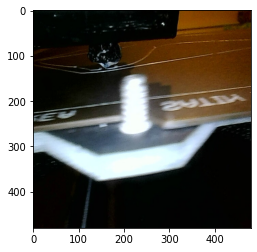

In [8]:
import matplotlib.pyplot as plt

# for i in range(10):
# plt.imshow(trainX[0])
# plt.imshow(trainX[1])
# plt.imshow(trainX[2])
# plt.imshow(trainX[3])
plt.imshow(trainX[0])


In [9]:
# np.save(ROOT_DATA_PATH+'train_images_480_480', trainX)
# np.save(ROOT_DATA_PATH+'train_labels', trainY)

In [10]:
# trainX = np.load(ROOT_DATA_PATH+'train_images_480_480.npy')
# trainY = np.load(ROOT_DATA_PATH+'train_labels.npy')

# trainX, trainY

In [11]:
import numpy as np
import torch
        
class ConvNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, 
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):
        
        super().__init__()
        print("here")
        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers or
            len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')
        
        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu
        
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 3
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append( torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride) )
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append( torch.nn.Linear(n_in, nh) )
            n_in = nh
        self.fc_layers.append( torch.nn.Linear(n_in, n_outputs) )
        
        self.to(self.device)


    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append( self.activation_function(conv_layer(Ys[-1])) )

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append( self.activation_function(fc_layer(Ys[-1].reshape(n_samples, -1))) )
            else:
                Ys.append( self.activation_function(fc_layer(Ys[-1])) )

        Ys.append(self.fc_layers[-1](Ys[-1]))
        return Ys


    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]
    

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        
        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch
        
        X = torch.permute(X, (0, 3, 1, 2))
        X.requires_grad_(True)

        self.classes = torch.unique(T)
        
        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []
        
        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0
            
            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]
                
                Y = self.forward(X_batch)
                # print(Y.shape, Y)
                # print(T_batch.shape, T_batch)
                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self


    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y


    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        
        X = torch.permute(X, (0, 3, 1, 2))

        Y = self.forward(X)
        probs = self.softmax(Y)
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()]
        return classes.cpu().numpy(), probs.detach().cpu().numpy()


In [17]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [18]:
# np.random.seed(42)
# r_indexes = np.arange(len(trainX))
# np.random.shuffle(r_indexes)

# trainX = trainX[r_indexes]
# trainY = trainY[r_indexes]

In [19]:
cnnet = ConvNet(480 * 480,
                [10, 20], # n_hiddens_per_conv_layer
                [5], # n_hiddens_per_fc_layer
                2,
                patch_size_per_conv_layer=[5, 7], stride_per_conv_layer=[2, 2], device=device)
cnnet.to(device)


here


ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=269120, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=2, bias=True)
  )
)

In [20]:
trainY.reshape(1,-1)[0]

array([1, 1, 1, ..., 0, 0, 0])

In [21]:


n_epochs = 10
batch_size = 100
learning_rate = 0.001
cnnet.train(trainX, trainY.reshape(1,-1)[0], batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 1 Loss 0.793
adam: Epoch 2 Loss 0.687
adam: Epoch 3 Loss 0.690
adam: Epoch 4 Loss 0.699
adam: Epoch 5 Loss 0.704
adam: Epoch 6 Loss 0.706
adam: Epoch 7 Loss 0.707
adam: Epoch 8 Loss 0.707
adam: Epoch 9 Loss 0.707
adam: Epoch 10 Loss 0.708


ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=269120, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=2, bias=True)
  )
)

In [ ]:
predictedTrainClasses, _ = cnnet.use(trainX)
try:
    print(classification_report(trainY, predictedTrainClasses, zero_division=0, digits=7))
except:
    print(classification_report(trainY.reshape(1,-1)[0], predictedTrainClasses, zero_division=0, digits=7))
    # trainY.reshape(1,-1)[0]
print("loading test data")

testX, test_paths = get_images_and_targets(test_labels, images, test=True)

predictedYClasses, _ = cnnet.use(testX)

results = np.hstack((test_paths, predictedYClasses))
results_df = pd.DataFrame(results, columns=['img_path', 'has_under_extrusion'])
results_df.to_csv('./results_notebook.csv', index=False)
# print(classification_report(trainy, predictedTrain, zero_division=0, digits=7))
